In [10]:
# ==========================================
# 📦 Import Libraries
# ==========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, average_precision_score,
    classification_report, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")


In [11]:
# ==========================================
# 🧩 Load Dataset
# ==========================================

# Example dataset (replace this with your own)
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=20, n_informative=10,
    n_redundant=5, weights=[0.9, 0.1],
    random_state=42
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Before resampling:")
print(pd.Series(y_train).value_counts())


Before resampling:
0    3135
1     365
Name: count, dtype: int64


In [12]:
# ==========================================
# ⚖️ Resample Data using SMOTE + Tomek
# ==========================================
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print("After resampling:")
print(pd.Series(y_train_res).value_counts())


After resampling:
0    3135
1    3135
Name: count, dtype: int64


In [13]:
# ==========================================
# 🤖 Define All Models
# ==========================================

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),
                             use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42)
}


In [14]:
# ==========================================
# 🧮 Train and Evaluate Each Model
# ==========================================
results = []
roc_curves = {}
pr_curves = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    results.append([name, precision, recall, f1, bal_acc, mcc, roc_auc, pr_auc])
    
    # Curves
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr)
    pr_curves[name] = (rec, prec)

# Results DataFrame
results_df = pd.DataFrame(results, columns=[
    "Model", "Precision", "Recall", "F1 Score", "Balanced Accuracy",
    "MCC", "ROC AUC", "PR AUC"
])
display(results_df)



🔹 Training Logistic Regression...

🔹 Training Decision Tree...

🔹 Training Random Forest...

🔹 Training XGBoost...


C:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:18:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 Training SVM...


,Model,Precision,Recall,F1 Score,Balanced Accuracy,MCC,ROC AUC,PR AUC
0,Logistic Regression,0.380240,0.814103,0.518367,0.830042,0.484327,0.888941,0.641247
1,Decision Tree,0.495455,0.698718,0.579787,0.808064,0.531639,0.808064,0.377516
2,Random Forest,0.880000,0.705128,0.782918,0.846984,0.766469,0.952763,0.873557
3,XGBoost,0.829932,0.782051,0.805281,0.881725,0.783854,0.951503,0.877099
4,SVM,0.812500,0.833333,0.822785,0.905506,0.802004,0.963804,0.896621


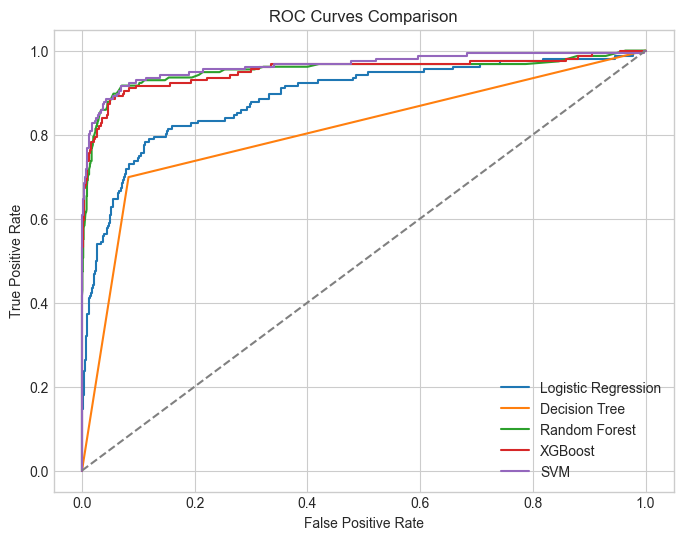

In [15]:
# ==========================================
# 📈 ROC Curves
# ==========================================
plt.figure(figsize=(8,6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()


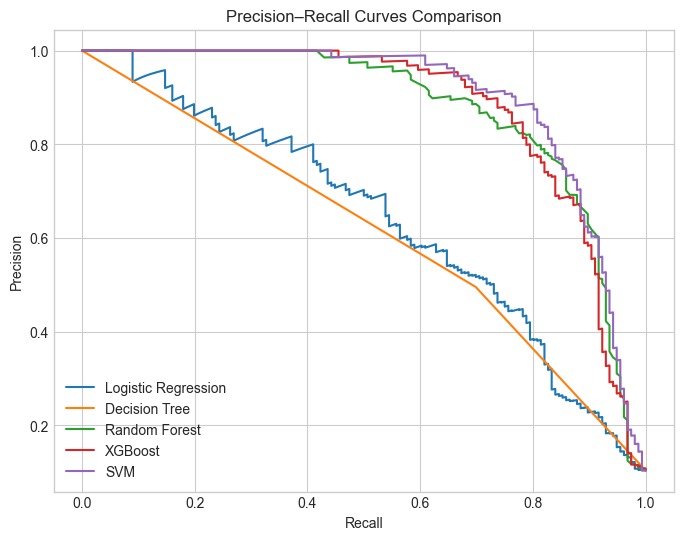

In [16]:
# ==========================================
# 📉 Precision–Recall Curves
# ==========================================
plt.figure(figsize=(8,6))
for name, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves Comparison")
plt.legend()
plt.show()


In [17]:
# ==========================================
# 🏆 Compare Models
# ==========================================
results_df_sorted = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)
display(results_df_sorted.style.background_gradient(cmap="Blues", axis=0))


,Model,Precision,Recall,F1 Score,Balanced Accuracy,MCC,ROC AUC,PR AUC
0,SVM,0.812500,0.833333,0.822785,0.905506,0.802004,0.963804,0.896621
1,XGBoost,0.829932,0.782051,0.805281,0.881725,0.783854,0.951503,0.877099
2,Random Forest,0.880000,0.705128,0.782918,0.846984,0.766469,0.952763,0.873557
3,Decision Tree,0.495455,0.698718,0.579787,0.808064,0.531639,0.808064,0.377516
4,Logistic Regression,0.380240,0.814103,0.518367,0.830042,0.484327,0.888941,0.641247
